# 1.Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
#df=pd.read_csv('./Data/data_9_5day.csv')
XL=pd.read_csv('9_510_L_resample.csv')
XU_train=pd.read_csv('9_510_U_resample.csv')# No resampling done in the unlabeled set, It just denotes the pair of L and U

In [4]:
from sklearn.utils import shuffle
#df = shuffle(df).reset_index(drop=True)
XU_train.head()

,Source.IP,Source.Port,Destination.IP,Destination.Port,Protocol,Timestamp,Flow.Duration,Total.Fwd.Packets,Total.Backward.Packets,Fwd.Packet.Length.Max,...,act_data_pkt_fwd,min_seg_size_forward,Active.Mean,Active.Std,Active.Max,Active.Min,Idle.Mean,Idle.Std,Idle.Max,Idle.Min
0,180881161,3128,3232243823,51203,6,1.494314e+09,106,2,0,55,...,1,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3193625889,80,180881369,52177,6,1.494322e+09,483,1,2,0,...,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3232246019,55151,180881158,3128,6,1.494314e+09,22692370,5,3,739,...,4,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,180881351,34795,3193625907,80,6,1.494314e+09,245206,3,6,3017,...,1,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3232243719,51563,180881160,3128,6,1.494318e+09,10188,1,1,6,...,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
XL.head()

,Source.IP,Source.Port,Destination.IP,Destination.Port,Protocol,Timestamp,Flow.Duration,Total.Fwd.Packets,Total.Backward.Packets,Fwd.Packet.Length.Max,...,min_seg_size_forward,Active.Mean,Active.Std,Active.Max,Active.Min,Idle.Mean,Idle.Std,Idle.Max,Idle.Min,ProtocolName
0,180881370,51010,915964343,80,6,1.494319e+09,233,1,1,0,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AMAZON
1,3232256328,57128,180881160,3128,6,1.494322e+09,1778,3,0,6,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AMAZON
2,180881370,41620,872483344,80,6,1.494318e+09,743839,11,8,284,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AMAZON
3,180881346,42382,872820700,443,6,1.494322e+09,9683828,8,9,1471,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AMAZON
4,180881370,47404,915964343,80,6,1.494318e+09,24,1,1,0,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,AMAZON


In [6]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler 

Using TensorFlow backend.


In [7]:
a=XL.groupby('ProtocolName')['ProtocolName'].count().sort_values(ascending=False)


In [8]:
a   # see resampled instances

ProtocolName
YOUTUBE           6000
SSL               6000
GOOGLE            6000
HTTP              6000
HTTP_CONNECT      6000
HTTP_PROXY        6000
AMAZON            6000
TEAMVIEWER        5000
WIKIPEDIA         5000
GOOGLE_MAPS       5000
WINDOWS_UPDATE    5000
GMAIL             5000
FTP_DATA          5000
FACEBOOK          5000
EBAY              5000
EASYTAXI          5000
DROPBOX           5000
DNS               5000
CONTENT_FLASH     5000
CLOUDFLARE        5000
CITRIX_ONLINE     5000
APPLE_ITUNES      5000
APPLE_ICLOUD      5000
APPLE             5000
H323              5000
WHATSAPP          5000
SSL_NO_CERT       5000
HTTP_DOWNLOAD     5000
TOR               5000
SPOTIFY           5000
SKYPE             5000
OFFICE_365        5000
NTP               5000
NETFLIX           5000
MS_ONE_DRIVE      5000
MSSQL             5000
MSN               5000
MQTT              5000
MICROSOFT         5000
LASTFM            5000
IP_ICMP           5000
YAHOO             5000
TWITTER           500

In [9]:
'''
Function mask_noise

Input: numpy array , fraction_delete(between 0 and 1)

Removes a fraction_delete fraction of the input array X randomly

Output: numpy array after deletions

'''
def mask_noise(X,fraction_delete=0.2):
    mask=np.random.rand(np.shape(X)[0],np.shape(X)[1])
    mask=1*(mask>fraction_delete)
    return mask*X

In [10]:
'''
Function Gaussian_noise

Input: numpy array , sigma

adds noise distributed normally with a stddev sigma 

Output: numpy array after adding noise

'''
def Gaussian_noise(X,sigma=0.5):
    noise = np.random.normal(0,sigma,np.shape(X))
    return noise+X

In [11]:
from keras.layers import Input, Dense
from keras.models import Model
import keras.backend as K
import tensorflow as tf

In [12]:
'''
Sparcity Autoencoder's Sparcity Activity Regularization

'''
def kl_divergence(rho, rho_hat):
    return rho * tf.math.log(rho) - rho * tf.math.log(rho_hat+1e-12) + (1 - rho) * tf.math.log(1 - rho) - (1 - rho) * tf.math.log(1 - rho_hat+1e-12)

class SparseActivityRegularizer(tf.keras.regularizers.Regularizer):

    def __init__(self, p=0.1, sparsityBeta=3):
        self.p = p
        self.sparsityBeta = sparsityBeta

    def __call__(self, x):
        regularization = 0            

        p_hat = K.mean(x, axis=0)
        regularization += self.sparsityBeta * K.sum(kl_divergence(self.p, p_hat))

        return regularization

    def get_config(self):
        return {"name": self.__class__.__name__} 

In [13]:
from keras.layers import BatchNormalization
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras.optimizers import Adagrad
from keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder

In [14]:
yL_train=XL.iloc[:,-1]
XL_train=XL.iloc[:,:-1]

In [15]:
yL_train=pd.get_dummies(yL_train)#One-hotencoding

# Split into train,test and val

#randomly split into train(80%) and val(20%)
XL_train,XL_val,yL_train,yL_val=train_test_split(XL_train,yL_train,random_state=0,test_size=0.2)

#randomly split val into val(10%) and test(10%)
XL_val,XL_test,yL_val,yL_test=train_test_split(XL_val,yL_val,random_state=0,test_size=0.5)

In [16]:
yL_train2=yL_train[yL_train==1].stack().reset_index().drop(0,1)['level_1'] # reversing the one hot encoding for each set

In [17]:
yL_val2=yL_val[yL_val==1].stack().reset_index().drop(0,1)['level_1']# reversing the one hot encoding for each set

In [18]:
yL_test2=yL_test[yL_test==1].stack().reset_index().drop(0,1)['level_1']# reversing the one hot encoding for each set

In [19]:
'''
b=a.where(a>5000)
b=b.fillna(5000,downcast='infer')
threshold=dict(zip(b.index,b.values))
ros=RandomOverSampler(sampling_strategy=threshold,random_state=0)
Xi=XL_train
yi=yL_train
X1,y1=ros.fit_resample(Xi,yi)
b=b.where(b<6000)
b=b.fillna(6000,downcast='infer')
threshold=dict(zip(b.index,b.values))
rus=RandomUnderSampler(sampling_strategy=threshold,random_state=0)
XL_train,yL_train=rus.fit_resample(X1,y1)
'''

"\nb=a.where(a>5000)\nb=b.fillna(5000,downcast='infer')\nthreshold=dict(zip(b.index,b.values))\nros=RandomOverSampler(sampling_strategy=threshold,random_state=0)\nXi=XL_train\nyi=yL_train\nX1,y1=ros.fit_resample(Xi,yi)\nb=b.where(b<6000)\nb=b.fillna(6000,downcast='infer')\nthreshold=dict(zip(b.index,b.values))\nrus=RandomUnderSampler(sampling_strategy=threshold,random_state=0)\nXL_train,yL_train=rus.fit_resample(X1,y1)\n"

In [20]:

'''

yL_train=pd.get_dummies(yL_train)
yL_test=pd.get_dummies(yL_test)
yL_val=pd.get_dummies(yL_test)

yL_val=yL_val.iloc[:-42]
yL_test=yL_test.iloc[:-42]
yL_train=yL_train.iloc[:-42]

'''

'\n\nyL_train=pd.get_dummies(yL_train)\nyL_test=pd.get_dummies(yL_test)\nyL_val=pd.get_dummies(yL_test)\n\nyL_val=yL_val.iloc[:-42]\nyL_test=yL_test.iloc[:-42]\nyL_train=yL_train.iloc[:-42]\n\n'

In [21]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
scaler=StandardScaler()


#XU_train=normalize(XU_train,norm='l1')
#XL_train=normalize(XL_train,norm='l1')
#XL_val=normalize(XL_val,norm='l1')
#XL_test=normalize(XL_test,norm='l1')


#scaling and normalization
XU_train=scaler.fit_transform(XU_train)
XL_train=scaler.fit_transform(XL_train)
XL_val=scaler.transform(XL_val)
XL_test=scaler.transform(XL_test)


# 2. Training the SDAE

In [22]:
from keras_sequential_ascii import keras2ascii
from tensorflow.keras import regularizers
from keras.models import Sequential

In [23]:
from keras import backend as K


In [24]:
'''
Function SDAE
Inputs: numpy array X, list layers,list activations,float fraction_delete
layers is a list of no. of hidden nodes in each hidden layer
activations is a list of activations used in each encoding layer
trains each autoencoder layer and outputs all the encoder-layer models.
Output: a list of keras models

'''
def SDAE(X,layers,activations,rho,n_epochs,denoise,fraction_delete=0.2):
    layers.insert(0,len(X[0]))
    #layers.insert(0,len(X_train.iloc[0]))
    ec=[]
    for i in range(len(layers)-1):
        encoding_dim = layers[i+1]

    # this is our input placeholder
        input_ = Input(shape=(layers[i],))
    # define regulariser
        if rho[i] != None: 
            regulariser = SparseActivityRegularizer(rho[i],3)
        else:
            regulariser=None

        # "encoded" is the encoded representation of the input
        encoded = Dense(encoding_dim, activation=activations[i],bias_initializer='random_normal',kernel_initializer='he_uniform',activity_regularizer=regulariser,name='encoder'+str(i+1))(input_)
        
        # "decoded" is the lossy reconstruction of the input
        decoded = Dense(layers[i],activation=None,name='decoder'+str(i+1))(encoded)

        # this model maps an input to its reconstruction
        autoencoder = Model(input_, decoded)

        # this model maps an input to its encoded representation
        encoder = Model(input_, encoded)

        # create a placeholder for an encoded (32-dimensional) input
        encoded_input = Input(shape=(encoding_dim,))

        autoencoder.compile(optimizer=RMSprop(learning_rate=0.001,clipnorm=0.1), loss='mse')
        if denoise =='Gauss':
            X_noisy=Gaussian_noise(X,fraction_delete)
        else:
            X_noisy=mask_noise(X,fraction_delete)
            
        #print(X_noisy)
        #print(X)
        #autoencoder.summary()
        #keras2ascii(autoencoder)
        
        print('Training Layer ' + str(i+1)+' : ')
        autoencoder.fit(X_noisy,X,
                epochs=n_epochs,
                batch_size=256,
                shuffle=True,
                validation_data=(X,X))
        ec.append(encoder)
        #print(autoencoder.predict(mask_noise(X,1.0)))
        X=encoder.predict(X)
        #print(np.mean(X,axis=0))
    print('All Layers Done!')    
    return ec       

In [39]:
#XU_train,XL_train,yU_train,yL_train=train_test_split(X_train,y_train,random_state=0,test_size=0.5)
#train Sparse Stacked Denoising Autoencoder
layers = [100,200,400,50]
activations=['relu','relu','relu','relu','relu']
rho=[0.09,0.09,0.09,0.09,0.1,0.1]
stacked_layers=SDAE(XU_train,layers,activations,rho,20,'mask',0.03)

Training Layer 1 : 
Train on 121392 samples, validate on 121392 samples
Epoch 1/20
121392/121392 [==============================] - 2s 15us/step - loss: 6.7559 - val_loss: 0.7336
Epoch 2/20
121392/121392 [==============================] - 2s 13us/step - loss: 0.6181 - val_loss: 0.5313
Epoch 3/20
121392/121392 [==============================] - 2s 14us/step - loss: 0.5025 - val_loss: 0.4254
Epoch 4/20
121392/121392 [==============================] - 2s 13us/step - loss: 0.4413 - val_loss: 0.4295
Epoch 5/20
121392/121392 [==============================] - 2s 15us/step - loss: 0.4080 - val_loss: 0.3663
Epoch 6/20
121392/121392 [==============================] - 2s 13us/step - loss: 0.3879 - val_loss: 0.3705
Epoch 7/20
121392/121392 [==============================] - 2s 14us/step - loss: 0.3592 - val_loss: 0.3351
Epoch 8/20
121392/121392 [==============================] - 2s 13us/step - loss: 0.3425 - val_loss: 0.3285
Epoch 9/20
121392/121392 [==============================] - 2s 14us/step

# 3.Training the SoftMax classifier

In [40]:
'''
Performs a Forward Pass through the SDAE

'''
def SDAE_predict(stacked_layers,X):
    for layer in stacked_layers:
        X1=layer.predict(X)
        X=X1
    return X1    

In [41]:
#forward pass through SDAE
XL_train1=SDAE_predict(stacked_layers,XL_train)
XL_val1=SDAE_predict(stacked_layers,XL_val)
XL_test1=SDAE_predict(stacked_layers,XL_test)

### Please skip this section to part 6 If only ML methods are to be tested, The following is the DL model

In [42]:
from tensorflow.keras import regularizers

In [43]:
#Train Classifier separately
input1 = Input(shape=(layers[-1],))
#bn1=BatchNormalization()(input1)
#L0 = Dense(100,activation='relu')(bn1) #if one wishes to include another layer, just uncomment
L1 = Dense(len(yL_train.columns),activation='softmax')(input1)
classifier=Model(input1,L1)
classifier.compile(optimizer=SGD(learning_rate=0.1,momentum=0.9),loss='categorical_crossentropy',metrics=['accuracy'])

In [44]:
history=classifier.fit(XL_train1,yL_train,
                epochs=50,
                #batch_size=256,
                shuffle=True,
                validation_data=(XL_val1, yL_val))

Train on 181600 samples, validate on 22700 samples
Epoch 1/50
181600/181600 [==============================] - 5s 28us/step - loss: 2.9037 - accuracy: 0.2836 - val_loss: 2.6600 - val_accuracy: 0.3363
Epoch 2/50
181600/181600 [==============================] - 5s 28us/step - loss: 2.5811 - accuracy: 0.3487 - val_loss: 2.4975 - val_accuracy: 0.3663
Epoch 3/50
181600/181600 [==============================] - 5s 29us/step - loss: 2.4668 - accuracy: 0.3683 - val_loss: 2.4186 - val_accuracy: 0.3770
Epoch 4/50
181600/181600 [==============================] - 5s 29us/step - loss: 2.4014 - accuracy: 0.3844 - val_loss: 2.3615 - val_accuracy: 0.3993
Epoch 5/50
181600/181600 [==============================] - 5s 28us/step - loss: 2.3584 - accuracy: 0.3936 - val_loss: 2.3230 - val_accuracy: 0.4077
Epoch 6/50
181600/181600 [==============================] - 5s 28us/step - loss: 2.3265 - accuracy: 0.4013 - val_loss: 2.2940 - val_accuracy: 0.4084
Epoch 7/50
181600/181600 [=============================

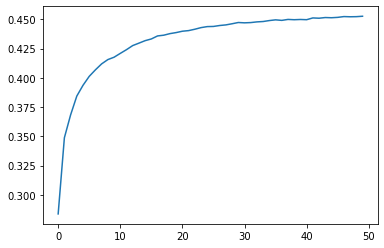

In [45]:
plt.plot(history.history['accuracy'])

# 4. Fine Tuning

In [46]:
from tensorflow.keras import regularizers
from keras.models import load_model
import keras
from keras.layers import Dropout

In [47]:
# change regularisation settings
a=[]
#input2=Input(shape=(len(XL_train[0]),))
#a.append(input2)
for i in range(len(stacked_layers)):
    encoder=stacked_layers[i]
    encoder.layers[-1].kernel_regularizer=None #set or reset weight regularizer 
    encoder.layers[-1].activity_regularizer=None #remove Sparse activity regularizer
    encoder.save('temp.h5')
    encoder=load_model('temp.h5')
    print(encoder.losses)
    a.append(encoder)
    #a.append(tf.keras.backend.dropout(a[i],0.2))
    
#classifier.layers[-1].kernel_regularizer=regularizers.l2(0.0001)#set or reset weight regularizer 
classifier.save('temp.h5')
classifier=load_model('temp.h5')
print(classifier.losses)
a.append(classifier)    

c:\users\dhruvjyoti\appdata\local\programs\python\python37\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


[]
[]
[]
[]
[]


In [48]:
# add dropout till n-2 layers
from keras.models import Sequential
model=Sequential()
for i in a:
    model.add(i)
    if i != classifier and i != encoder:
        model.add(Dropout(0.02))

In [49]:
#final fine tuned model
model.layers

In [51]:
model.save('temp.h5')
model=load_model('temp.h5')

In [52]:
model.compile(optimizer=RMSprop(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [53]:
#fine tune
history=model.fit(XL_train,yL_train,
                epochs=300,
                batch_size=256,
                shuffle=True,
                validation_data=(XL_val, yL_val))

Train on 181600 samples, validate on 22700 samples
Epoch 1/300
102144/181600 [===============>..............] - ETA: 3s - loss: 2.0649 - accuracy: 0.4572

KeyboardInterrupt: 

In [54]:
model.evaluate(XL_test,yL_test)

22700/22700 [==============================] - 1s 33us/step


[1.6652489478997723, 0.5479295253753662]

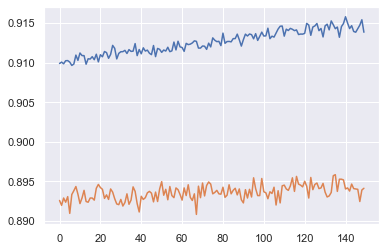

In [140]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# 5. Results

In [141]:
y_pred=model.predict(XL_test)
y_pred

array([[1.2913923e-14, 3.0351409e-16, 3.5164938e-21, ..., 1.1380052e-18,
        1.9137769e-11, 4.1763305e-06],
       [4.9162604e-04, 9.3076178e-09, 4.8519864e-12, ..., 3.2606172e-07,
        3.5962557e-07, 1.3435394e-07],
       [7.1954773e-08, 4.8477481e-21, 7.7184126e-23, ..., 5.1185622e-10,
        1.1683595e-08, 1.3112775e-10],
       ...,
       [1.8238999e-11, 9.9996948e-01, 4.2627728e-09, ..., 7.0772365e-13,
        2.0799262e-11, 1.6600808e-08],
       [6.2613909e-10, 7.3030949e-11, 3.5931952e-17, ..., 7.5679242e-13,
        5.4761886e-06, 2.3616825e-12],
       [4.9030415e-11, 6.1379789e-15, 3.0997163e-10, ..., 1.5042368e-11,
        2.5878926e-12, 1.0793907e-05]], dtype=float32)

In [142]:
y_pred1=y_pred.argmax(axis=1)
y_pred1=np.append(y_pred1,np.arange(42))
y_pred1=pd.get_dummies(y_pred1,columns=yL_train.columns)
y_pred1.columns=yL_test.columns
y_pred1=y_pred1.iloc[:-42]

In [143]:
(yL_test!=0).sum().sum()

22700

In [144]:
#y_test1 = yL_test.columns[np.where(yL_test!=0)[1]]

In [145]:
#y_test1

In [30]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [147]:
yL_test.sum()

AMAZON            600
APPLE             496
APPLE_ICLOUD      477
APPLE_ITUNES      517
CITRIX_ONLINE     477
CLOUDFLARE        472
CONTENT_FLASH     521
DNS               481
DROPBOX           481
EASYTAXI          528
EBAY              513
FACEBOOK          523
FTP_DATA          483
GMAIL             502
GOOGLE            623
GOOGLE_MAPS       476
H323              486
HTTP              602
HTTP_CONNECT      596
HTTP_DOWNLOAD     495
HTTP_PROXY        616
INSTAGRAM         485
IP_ICMP           467
LASTFM            495
MICROSOFT         492
MQTT              501
MSN               513
MSSQL             511
MS_ONE_DRIVE      551
NETFLIX           522
NTP               491
OFFICE_365        529
SKYPE             484
SPOTIFY           506
SSL               596
SSL_NO_CERT       505
TEAMVIEWER        496
TOR               502
TWITTER           501
WHATSAPP          496
WIKIPEDIA         475
WINDOWS_UPDATE    497
YAHOO             493
YOUTUBE           627
dtype: int64

In [148]:
#y_pred1=y_pred1.drop(yL_test.sum().index[list(np.where(yL_test.sum()==0)[0])],axis=1)
#yL_test=yL_test.drop(yL_test.sum().index[list(np.where(yL_test.sum()==0)[0])],axis=1)

In [149]:
y_test1 = yL_test.columns[np.where(yL_test!=0)[1]]

In [150]:
y_pred1=y_pred1.columns[np.where(y_pred1!=0)[1]]
y_pred1

Index(['GOOGLE_MAPS', 'MSN', 'CONTENT_FLASH', 'FTP_DATA', 'HTTP_PROXY', 'NTP',
       'MICROSOFT', 'LASTFM', 'WINDOWS_UPDATE', 'DROPBOX',
       ...
       'GOOGLE', 'EASYTAXI', 'INSTAGRAM', 'FTP_DATA', 'MSN', 'GOOGLE_MAPS',
       'CONTENT_FLASH', 'APPLE', 'FTP_DATA', 'SKYPE'],
      dtype='object', length=22700)

In [151]:
cm=confusion_matrix(y_test1,y_pred1,labels=yL_test.columns)

In [152]:
cm_pc=pd.DataFrame((cm.T/np.sum(cm,axis=1)).T,columns=yL_test.columns,index=yL_test.columns)
cm_pc=cm_pc.replace(np.nan,0)


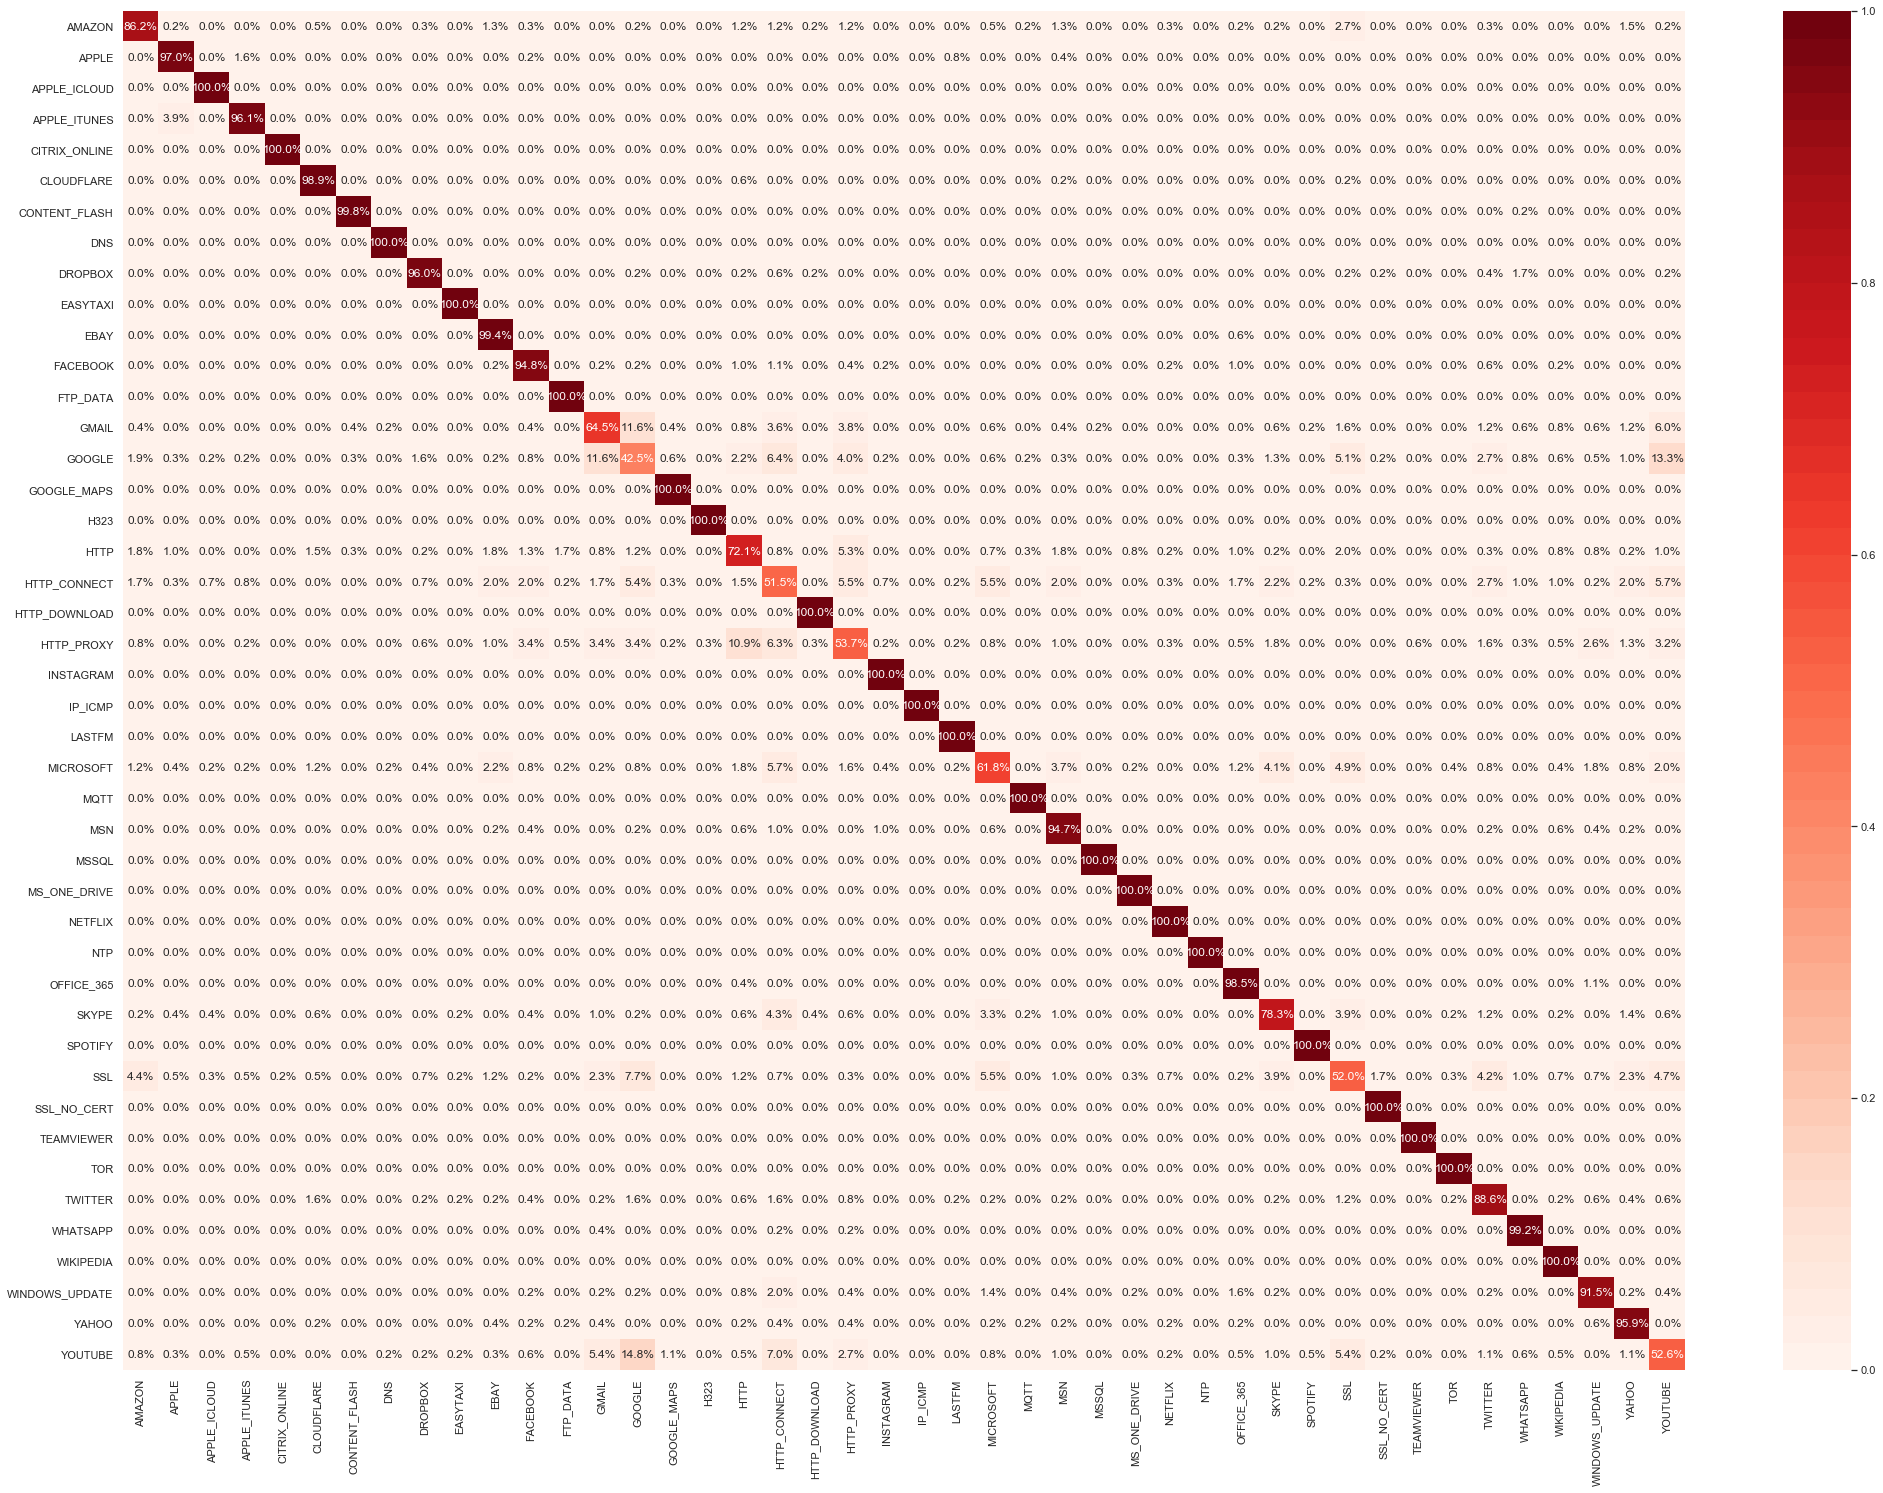

In [153]:
plt.figure(figsize=(35,25))
df_cm=pd.DataFrame(cm,columns=yL_test.columns,index=yL_test.columns)
sns.set(font_scale=1.0)
sns.heatmap(cm_pc, annot=True,fmt='.1%',cmap=sns.color_palette("Reds",50)) # font size
plt.show()

In [154]:
print('Test Accuracy : '+str(accuracy_score(y_test1, y_pred1)))

Test Accuracy : 0.8905286343612335


In [155]:
print('weighted F1 Score : ' + str(f1_score(y_pred1,y_test1,average = 'weighted')))
print('Macro F1 Score : ' + str(f1_score(y_pred1,y_test1,average = 'macro')))
print('Micro F1 Score : ' + str(f1_score(y_pred1,y_test1,average = 'micro')))
print('F1 Scores : ' )
pd.DataFrame(f1_score(y_pred1,y_test1,labels=yL_test.columns,average = None),columns=['F1-score'],index=yL_test.columns)

weighted F1 Score : 0.8951018519503067
Macro F1 Score : 0.8955458003918594
Micro F1 Score : 0.8905286343612335
F1 Scores : 


,F1-score
AMAZON,0.865272
APPLE,0.945919
APPLE_ICLOUD,0.989627
APPLE_ITUNES,0.959459
CITRIX_ONLINE,0.998953
CLOUDFLARE,0.960905
CONTENT_FLASH,0.993314
DNS,0.996891
DROPBOX,0.950617
EASYTAXI,0.996226


In [156]:
len(yL_train.columns)# No. of distinct labels

44

In [29]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [158]:
print('Macro Presicion : '+str(precision_score(y_test1, y_pred1,average="macro")))
print('Micro Presicion : '+str(precision_score(y_test1, y_pred1,average="micro")))
print('Weighted Presicion : '+str(precision_score(y_test1, y_pred1,average="weighted")))
print('Precision Scores : ' )
pd.DataFrame(precision_score(y_pred1,y_test1,labels=yL_test.columns,average = None),columns=['Precision-score'],index=yL_test.columns)

Macro Presicion : 0.8917709309544887
Micro Presicion : 0.8905286343612335
Weighted Presicion : 0.883588131048132
Precision Scores : 


,Precision-score
AMAZON,0.861667
APPLE,0.969758
APPLE_ICLOUD,1.000000
APPLE_ITUNES,0.961315
CITRIX_ONLINE,1.000000
CLOUDFLARE,0.989407
CONTENT_FLASH,0.998081
DNS,1.000000
DROPBOX,0.960499
EASYTAXI,1.000000


In [159]:
print('Macro Recall : '+str(recall_score(y_test1, y_pred1,average="macro")))
print('Micro Recall : '+str(recall_score(y_test1, y_pred1,average="micro")))
print('Weighted Recall : '+str(recall_score(y_test1, y_pred1,average="weighted")))
print('Recall Scores : ' )
pd.DataFrame(recall_score(y_pred1,y_test1,labels=yL_test.columns,average = None),columns=['recall-score'],index=yL_test.columns)

Macro Recall : 0.9013665648385332
Micro Recall : 0.8905286343612335
Weighted Recall : 0.8905286343612335
Recall Scores : 


,recall-score
AMAZON,0.868908
APPLE,0.923225
APPLE_ICLOUD,0.979466
APPLE_ITUNES,0.957611
CITRIX_ONLINE,0.997908
CLOUDFLARE,0.934000
CONTENT_FLASH,0.988593
DNS,0.993802
DROPBOX,0.940937
EASYTAXI,0.992481


# 6. ML methods

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# RF


In [80]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(random_state=0,max_features=None)
clf.fit(XL_train1,yL_train2)

RandomForestClassifier(max_features=None, random_state=0)

In [81]:
print(clf.score(XL_train1,yL_train2))# train accuracy
print(clf.score(XL_test1,yL_test2))# test accuracy

0.983920704845815
0.864273127753304


In [82]:
y_pred=clf.predict(XL_test1)

In [83]:
#y_pred[np.where(np.sum(y_pred,axis=1)==0),0]=1  # process rows with all zeros if any

In [84]:

print('weighted F1 Score : ' + str(f1_score(y_pred,yL_test2,average='weighted')))
print('weighted Precision : ' + str(precision_score(y_pred,yL_test2,average='weighted')))
print('weighted Recall : ' + str(recall_score(y_pred,yL_test2,average='weighted')))

weighted F1 Score : 0.8696102779947574
weighted Precision : 0.8819690265237563
weighted Recall : 0.864273127753304


# SVM

In [135]:
from sklearn.svm import SVC
clf=SVC(random_state=0,kernel='rbf').fit(XL_train1,yL_train2)

In [136]:
clf.score(XL_train1,yL_train2) # train accuracy

0.5512665198237885

In [137]:
clf.score(XL_test1,yL_test2) # test accuracy

0.55

In [138]:
y_pred=clf.predict(XL_test1)

In [139]:
print('weighted F1 Score : ' + str(f1_score(y_pred,yL_test2,average = 'weighted')))
print('weighted Precision : ' + str(precision_score(y_pred,yL_test2,average = 'weighted')))
print('weighted Recall : ' + str(recall_score(y_pred,yL_test2,average = 'weighted')))

weighted F1 Score : 0.567943422208222
weighted Precision : 0.6322466143073135
weighted Recall : 0.55


# Decision Tree

In [29]:
from sklearn.tree import DecisionTreeClassifier
clf=DecisionTreeClassifier(random_state=0,max_depth=20).fit(XL_train1,yL_train2)

In [30]:
clf.score(XL_train1,yL_train2) #train accuracy

0.690897577092511

In [31]:
clf.score(XL_test1,yL_test2)# test accuracy

0.6444052863436124

In [133]:
#y_pred[np.where(np.sum(y_pred,axis=1)==0),0]=1  # process rows with all zeros if any

In [34]:
y_pred=clf.predict(XL_test1)
print('weighted F1 Score : ' + str(f1_score(y_pred,yL_test2,average = 'weighted')))
print('weighted Precision : ' + str(precision_score(y_pred,yL_test2,average = 'weighted')))
print('weighted Recall : ' + str(recall_score(y_pred,yL_test2,average = 'weighted')))

weighted F1 Score : 0.6445420293703698
weighted Precision : 0.7235119488636761
weighted Recall : 0.6444052863436124
